

# Week 1: Multiple Output Models using the Keras Functional API

In this notebook, we will use the Keras functional API to train a model to predict two outputs. 

we will use the **[Wine Quality Dataset](https://archive.ics.uci.edu/ml/datasets/Wine+Quality)** from the **UCI machine learning repository**. It has separate datasets for red wine and white wine.

Normally, the wines are classified into one of the quality ratings specified in the attributes. In this exercise, we will combine the two datasets to predict the wine quality and whether the wine is red or white solely from the attributes. 

we will model wine quality estimations as a regression problem and wine type detection as a binary classification problem.

## Imports

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import itertools

import utils

## Load Dataset


we will now load the dataset from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/index.php) which are **already saved** in your workspace (*Note: For successful grading, please **do not** modify the default string set to the `URI` variable below*).

### Pre-process the white wine dataset
we will add a new column named `is_red` in your dataframe to indicate if the wine is white or red. 
- In the white wine dataset, we will fill the column `is_red` with  zeros (0).

In [2]:
# URL of the white wine dataset
URI = './data/winequality-white.csv'

# load the dataset from the URL
white_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with zeros.
white_df["is_red"] = 0

# keep only the first of duplicate items
white_df = white_df.drop_duplicates(keep='first')


In [4]:
print(white_df.alcohol[0])
print(white_df.alcohol[100])

8.8
9.1


### Pre-process the red wine dataset
- In the red wine dataset, we will fill in the column `is_red` with ones (1).

In [5]:
# URL of the red wine dataset
URI = './data/winequality-red.csv'

# load the dataset from the URL
red_df = pd.read_csv(URI, sep=";")

# fill the `is_red` column with ones.
red_df["is_red"] = 1

# keep only the first of duplicate items
red_df = red_df.drop_duplicates(keep='first')


In [7]:
print(red_df.alcohol[0])
print(red_df.alcohol[100])

9.4
10.2


### Concatenate the datasets

Next, concatenate the red and white wine dataframes.

In [8]:
df = pd.concat([red_df, white_df], ignore_index=True)

In [9]:
print(df.alcohol[0])
print(df.alcohol[100])


9.4
9.5


In a real-world scenario, we should shuffle the data. For this notebook however, **you are not** going to do that. if you want uncomment the next cell to shuffle

In [10]:
#df = df.iloc[np.random.permutation(len(df))]

This will chart the quality of the wines.

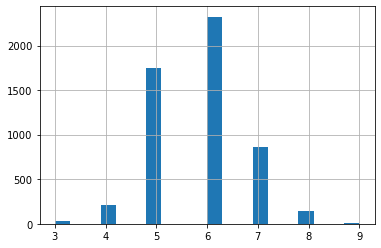

In [11]:
df['quality'].hist(bins=20);

### Imbalanced data
we can see from the plot above that the wine quality dataset is imbalanced. 
- Since there are very few observations with quality equal to 3, 4, 8 and 9, we can drop these observations from your dataset. 
- we can do this by removing data belonging to all classes except those > 4 and < 8.

In [12]:
# get data with wine quality greater than 4 and less than 8
df = df[(df['quality'] > 4) & (df['quality'] < 8 )]

# reset index and drop the old one
df = df.reset_index(drop=True)

In [14]:
print(df.alcohol[0])
print(df.alcohol[100])

9.4
10.9


we can plot again to see the new range of data and quality

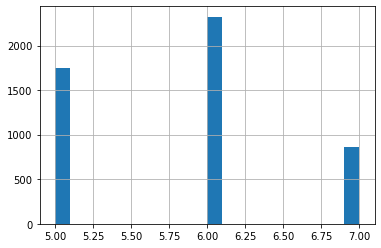

In [15]:
df['quality'].hist(bins=20);

### Train Test Split

Next, we can split the datasets into training, test and validation datasets.
- The data frame should be split 80:20 into `train` and `test` sets.
- The resulting `train` should then be split 80:20 into `train` and `val` sets.
- The `train_test_split` parameter `test_size` takes a float value that ranges between 0. and 1, and represents the proportion of the dataset that is allocated to the test set.  The rest of the data is allocated to the training set.

In [16]:
# Please do not change the random_state parameter. This is needed for grading.

# split df into 80:20 train and test sets
train, test = train_test_split(df, test_size=0.2, random_state = 1)
                               
# split train into 80:20 train and val sets
train, val = train_test_split(train, test_size=0.2, random_state = 1)

Here's where we can explore the training stats. we can pop the labels 'is_red' and 'quality' from the data as these will be used as the labels


In [18]:
train_stats = train.describe()
train_stats.pop('is_red')
train_stats.pop('quality')
train_stats = train_stats.transpose()

Explore the training stats!

In [19]:
train_stats

,count,mean,std,min,25%,50%,75%,max
fixed acidity,3155.0,7.221616,1.325297,3.80000,6.40000,7.00000,7.7000,15.60000
volatile acidity,3155.0,0.338929,0.162476,0.08000,0.23000,0.29000,0.4000,1.24000
citric acid,3155.0,0.321569,0.147970,0.00000,0.25000,0.31000,0.4000,1.66000
residual sugar,3155.0,5.155911,4.639632,0.60000,1.80000,2.80000,7.6500,65.80000
chlorides,3155.0,0.056976,0.036802,0.01200,0.03800,0.04700,0.0660,0.61100
free sulfur dioxide,3155.0,30.388590,17.236784,1.00000,17.00000,28.00000,41.0000,131.00000
total sulfur dioxide,3155.0,115.062282,56.706617,6.00000,75.00000,117.00000,156.0000,344.00000
density,3155.0,0.994633,0.003005,0.98711,0.99232,0.99481,0.9968,1.03898
pH,3155.0,3.223201,0.161272,2.72000,3.11000,3.21000,3.3300,4.01000
sulphates,3155.0,0.534051,0.149149,0.22000,0.43000,0.51000,0.6000,1.95000


### Get the labels

The features and labels are currently in the same dataframe.
- we will want to store the label columns `is_red` and `quality` separately from the feature columns.  
- The following function, `format_output`, gets these two columns from the dataframe (it's given to you).
- `format_output` also formats the data into numpy arrays. 
- Please use the `format_output` and apply it to the `train`, `val` and `test` sets to get dataframes for the labels.

In [20]:
def format_output(data):
    is_red = data.pop('is_red')
    is_red = np.array(is_red)
    quality = data.pop('quality')
    quality = np.array(quality)
    return (quality, is_red)

In [21]:
# format the output of the train set
train_Y = format_output(train)

# format the output of the val set
val_Y = format_output(val)
    
# format the output of the test set
test_Y = format_output(test)

Notice that after you get the labels, the `train`, `val` and `test` dataframes no longer contain the label columns, and contain just the feature columns.
- This is because you used `.pop` in the `format_output` function.

In [23]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
225,7.5,0.65,0.18,7.0,0.088,27.0,94.0,0.99915,3.38,0.77,9.4
3557,6.3,0.27,0.29,12.2,0.044,59.0,196.0,0.99782,3.14,0.40,8.8
3825,8.8,0.27,0.25,5.0,0.024,52.0,99.0,0.99250,2.87,0.49,11.4
1740,6.4,0.45,0.07,1.1,0.030,10.0,131.0,0.99050,2.97,0.28,10.8
1221,7.2,0.53,0.13,2.0,0.058,18.0,22.0,0.99573,3.21,0.68,9.9


# Normalize the data

Next, we can normalize the data, x, using the formula:
$$x_{norm} = \frac{x - \mu}{\sigma}$$
- The `norm` function is defined for you.
- Please apply the `norm` function to normalize the dataframes that contains the feature columns of `train`, `val` and `test` sets.

In [24]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [25]:
# normalize the train set
norm_train_X = norm(train)
    
# normalize the val set
norm_val_X = norm(val)
    
# normalize the test set
norm_test_X = norm(test)

## Define the Model

Define the model using the functional API. The base model will be 2 `Dense` layers of 128 neurons each, and have the `'relu'` activation.
- Check out the documentation for [tf.keras.layers.Dense](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense)

In [27]:
def base_model(inputs):
    
    # connect a Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation='relu')(inputs)
    
    # connect another Dense layer with 128 neurons and a relu activation
    x = Dense(units=128, activation='relu')(x)
    return x
  

# Define output layers of the model

we will add output layers to the base model. 
- The model will need two outputs.

One output layer will predict wine quality, which is a numeric value.
- Define a `Dense` layer with 1 neuron.
- Since this is a regression output, the activation can be left as its default value `None`.

The other output layer will predict the wine type, which is either red `1` or not red `0` (white).
- Define a `Dense` layer with 1 neuron.
- Since there are two possible categories, we can use a sigmoid activation for binary classification.

Define the `Model`
- Define the `Model` object, and set the following parameters:
  - `inputs`: pass in the inputs to the model as a list.
  - `outputs`: pass in a list of the outputs that you just defined: wine quality, then wine type.
  - **Note**: please list the wine quality before wine type in the outputs, as this will affect the calculated loss if you choose the other order.

In [29]:
def final_model(inputs):
    
    # get the base model
    x = base_model(inputs)

    # connect the output Dense layer for regression
    wine_quality = Dense(units='1', name='wine_quality')(x)

    # connect the output Dense layer for classification. this will use a sigmoid activation.
    wine_type = Dense(units='1', activation='sigmoid', name='wine_type')(x)

    # define the model using the input and output layers
    model = Model(inputs=[inputs], outputs=[wine_quality,wine_type])

    return model

# Compiling the Model

Next, compile the model. When setting the loss parameter of `model.compile`, you're setting the loss for each of the two outputs (wine quality and wine type).

To set more than one loss, use a dictionary of key-value pairs.
- we can look at the docs for the losses [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses#functions).
    - **Note**: For the desired spelling, please look at the "Functions" section of the documentation and not the "classes" section on that same page.
- wine_type: Since we will be performing binary classification on wine type, we should use the binary crossentropy loss function for it.  Please pass this in as a string.  
  - **Hint**, this should be all lowercase.  In the documentation, you'll see this under the "Functions" section, not the "Classes" section.
- wine_quality: since this is a regression output, use the mean squared error.  Please pass it in as a string, all lowercase.
  - **Hint**: You may notice that there are two aliases for mean squared error.  Please use the shorter name.


we will also set the metric for each of the two outputs.  Again, to set metrics for two or more outputs, use a dictionary with key value pairs.
- The metrics documentation is linked [here](https://www.tensorflow.org/api_docs/python/tf/keras/metrics).
- For the wine type, please set it to accuracy as a string, all lowercase.
- For wine quality, please use the root mean squared error.  Instead of a string, you'll set it to an instance of the class [RootMeanSquaredError](https://www.tensorflow.org/api_docs/python/tf/keras/metrics/RootMeanSquaredError), which belongs to the tf.keras.metrics module.

**Note**: If you see the error message 
>Exception: wine quality loss function is incorrect.

- Please also check your other losses and metrics, as the error may be caused by the other three key-value pairs and not the wine quality loss.

In [31]:
inputs = tf.keras.layers.Input(shape=(11,))
rms = tf.keras.optimizers.RMSprop(lr=0.0001)
model = final_model(inputs)

model.compile(optimizer=rms, 
                loss = {'wine_type' : 'binary_crossentropy',
                      'wine_quality' : 'mse'
                     },
              metrics = {'wine_type' : 'accuracy',
                         'wine_quality': tf.keras.metrics.RootMeanSquaredError()
                       }
             )


## Training the Model

Fit the model to the training inputs and outputs. 
- Check the documentation for [model.fit](https://www.tensorflow.org/api_docs/python/tf/keras/Model#fit).
- Remember to use the normalized training set as inputs. 
- For the validation data, please use the normalized validation set.

**Important: Please do not increase the number of epochs below. This is to avoid the grader from timing out. we can increase it once you have submitted your work.**

In [39]:
history = model.fit(norm_train_X,train_Y,
                    epochs = 40, validation_data=(norm_val_X,val_Y))

Train on 3155 samples, validate on 789 samples
Epoch 1/40
3155/3155 [==============================] - 0s 90us/sample - loss: 23.2538 - wine_quality_loss: 22.6634 - wine_type_loss: 0.5591 - wine_quality_root_mean_squared_error: 4.7639 - wine_type_accuracy: 0.7880 - val_loss: 15.8900 - val_wine_quality_loss: 15.3570 - val_wine_type_loss: 0.5466 - val_wine_quality_root_mean_squared_error: 3.9171 - val_wine_type_accuracy: 0.8466
Epoch 2/40
3155/3155 [==============================] - 0s 101us/sample - loss: 10.0943 - wine_quality_loss: 9.5658 - wine_type_loss: 0.5156 - wine_quality_root_mean_squared_error: 3.0950 - wine_type_accuracy: 0.8945 - val_loss: 5.3249 - val_wine_quality_loss: 4.8857 - val_wine_type_loss: 0.4772 - val_wine_quality_root_mean_squared_error: 2.2018 - val_wine_type_accuracy: 0.9455
Epoch 3/40
3155/3155 [==============================] - 0s 109us/sample - loss: 3.6365 - wine_quality_loss: 3.2151 - wine_type_loss: 0.4152 - wine_quality_root_mean_squared_error: 1.7947 - 

3155/3155 [==============================] - 0s 94us/sample - loss: 0.5862 - wine_quality_loss: 0.5483 - wine_type_loss: 0.0377 - wine_quality_root_mean_squared_error: 0.7405 - wine_type_accuracy: 0.9927 - val_loss: 0.5546 - val_wine_quality_loss: 0.5175 - val_wine_type_loss: 0.0358 - val_wine_quality_root_mean_squared_error: 0.7200 - val_wine_type_accuracy: 0.9937
Epoch 23/40
3155/3155 [==============================] - 0s 95us/sample - loss: 0.5614 - wine_quality_loss: 0.5243 - wine_type_loss: 0.0369 - wine_quality_root_mean_squared_error: 0.7242 - wine_type_accuracy: 0.9927 - val_loss: 0.5368 - val_wine_quality_loss: 0.5001 - val_wine_type_loss: 0.0352 - val_wine_quality_root_mean_squared_error: 0.7080 - val_wine_type_accuracy: 0.9937
Epoch 24/40
3155/3155 [==============================] - 0s 94us/sample - loss: 0.5360 - wine_quality_loss: 0.4997 - wine_type_loss: 0.0360 - wine_quality_root_mean_squared_error: 0.7071 - wine_type_accuracy: 0.9930 - val_loss: 0.5203 - val_wine_qualit

In [41]:
# Gather the training metrics
loss, wine_quality_loss, wine_type_loss, wine_quality_rmse, wine_type_accuracy = model.evaluate(x=norm_val_X, y=val_Y)

print()
print(f'loss: {loss}')
print(f'wine_quality_loss: {wine_quality_loss}')
print(f'wine_type_loss: {wine_type_loss}')
print(f'wine_quality_rmse: {wine_quality_rmse}')
print(f'wine_type_accuracy: {wine_type_accuracy}')

789/789 [==============================] - 0s 69us/sample - loss: 0.3726 - wine_quality_loss: 0.3405 - wine_type_loss: 0.0305 - wine_quality_root_mean_squared_error: 0.5846 - wine_type_accuracy: 0.9949

loss: 0.37263341287696317
wine_quality_loss: 0.34051695466041565
wine_type_loss: 0.030527576804161072
wine_quality_rmse: 0.5845798850059509
wine_type_accuracy: 0.9949302673339844


## Analyze the Model Performance

Note that the model has two outputs. The output at index 0 is quality and index 1 is wine type

So, round the quality predictions to the nearest integer.

In [42]:
predictions = model.predict(norm_test_X)
quality_pred = predictions[0]
type_pred = predictions[1]

In [43]:
print(quality_pred[0])

[5.6135216]


In [44]:
print(type_pred[0])
print(type_pred[944])

[0.0037269]
[0.99991274]


### Plot Utilities

We define a few utilities to visualize the model performance.

In [45]:
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)


In [46]:
def plot_confusion_matrix(y_true, y_pred, title='', labels=[0,1]):
    cm = confusion_matrix(test_Y[1], np.round(type_pred), labels=[0, 1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=[0, 1])
    disp.plot(values_format='d');

In [47]:
def plot_diff(y_true, y_pred, title = '' ):
    plt.scatter(y_true, y_pred)
    plt.title(title)
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot([-100, 100], [-100, 100])
    return plt

### Plots for Metrics

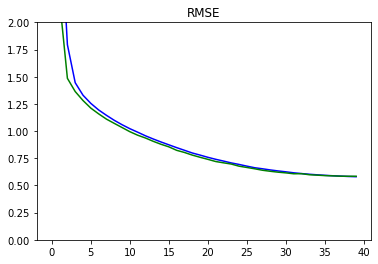

In [48]:
plot_metrics('wine_quality_root_mean_squared_error', 'RMSE', ylim=2)

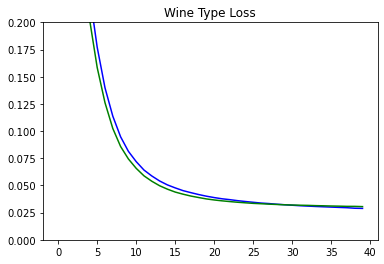

In [49]:
plot_metrics('wine_type_loss', 'Wine Type Loss', ylim=0.2)

### Plots for Confusion Matrix

Plot the confusion matrices for wine type. we can see that the model performs well for prediction of wine type from the confusion matrix and the loss metrics.

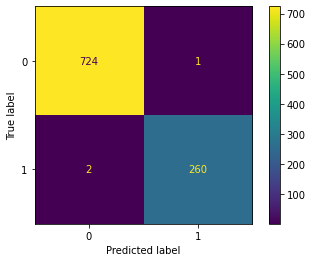

In [50]:
plot_confusion_matrix(test_Y[1], np.round(type_pred), title='Wine Type', labels = [0, 1])

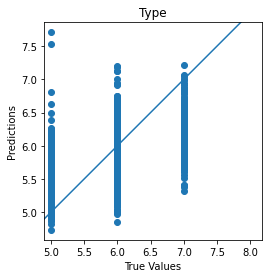

In [51]:
scatter_plot = plot_diff(test_Y[0], quality_pred, title='Type')